# 1D HDF Data Extraction

## Overview

This notebook demonstrates extracting and analyzing 1D unsteady flow results from HEC-RAS HDF5 output files. You'll learn how to:

- Extract water surface elevation (WSE), velocity, and flow time series from cross sections
- Access 1D-specific result datasets in the HDF5 file structure
- Validate extracted data against expected hydraulic ranges
- Create reviewable outputs for engineering QA/QC

### HDF5 File Structure for 1D Unsteady Results

HEC-RAS 6.x stores 1D unsteady results in HDF5 format with the following hierarchy:

```
/Results/Unsteady/Output/
├── Output Blocks/
│   └── Base Output/
│       ├── Unsteady Time Series/
│       │   ├── Cross Sections/        # WSE, velocity, flow by XS
│       │   ├── 2D Flow Areas/
│       │   └── Storage Areas/
│       └── Summary Output/
│           └── Cross Sections/        # Max WSE, velocity, etc.
```

**Key datasets**:
- **Water Surface** - Elevation in feet (or meters)
- **Velocity** - Average channel velocity in ft/s (or m/s)
- **Flow** - Total flow in cfs (or cms)

### Reference Documentation

For detailed information on HEC-RAS HDF5 output structure:
- [HEC-RAS User's Manual, Chapter 9: Viewing Results](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS Hydraulic Reference Manual](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx) - Hydraulic computations
- [HDF Group Documentation](https://www.hdfgroup.org/solutions/hdf5/) - HDF5 file format specification

### LLM Forward Engineering Principles

This notebook follows **LLM Forward** principles for hydraulic model analysis:

1. **Multi-Level Verifiability**: Results are exported to CSV for traditional engineering review
2. **Visual Outputs**: Plots generated for each extraction step
3. **Audit Trail**: All extraction parameters logged and documented
4. **Human-in-the-Loop**: Clear success criteria for reviewing extracted data

See [Engineering with LLMs](https://engineeringwithllms.info) for more on LLM Forward approach.

## Overview

This notebook demonstrates extracting and analyzing 1D unsteady flow results from HEC-RAS HDF5 output files. You'll learn how to:

- Extract water surface elevation (WSE), velocity, and flow time series from cross sections
- Access 1D-specific result datasets in the HDF5 file structure
- Validate extracted data against expected hydraulic ranges
- Create reviewable outputs for engineering QA/QC

### HDF5 File Structure for 1D Unsteady Results

HEC-RAS 6.x stores 1D unsteady results in HDF5 format with the following hierarchy:

```
/Results/Unsteady/Output/
├── Output Blocks/
│   └── Base Output/
│       ├── Unsteady Time Series/
│       │   ├── Cross Sections/        # WSE, velocity, flow by XS
│       │   ├── 2D Flow Areas/
│       │   └── Storage Areas/
│       └── Summary Output/
│           └── Cross Sections/        # Max WSE, velocity, etc.
```

**Key datasets**:
- **Water Surface** - Elevation in feet (or meters)
- **Velocity** - Average channel velocity in ft/s (or m/s)
- **Flow** - Total flow in cfs (or cms)

### Reference Documentation

For detailed information on HEC-RAS HDF5 output structure:
- [HEC-RAS User's Manual, Chapter 9: Viewing Results](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS Hydraulic Reference Manual](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx) - Hydraulic computations
- [HDF Group Documentation](https://www.hdfgroup.org/solutions/hdf5/) - HDF5 file format specification

### LLM Forward Engineering Principles

This notebook follows **LLM Forward** principles for hydraulic model analysis:

1. **Multi-Level Verifiability**: Results are exported to CSV for traditional engineering review
2. **Visual Outputs**: Plots generated for each extraction step
3. **Audit Trail**: All extraction parameters logged and documented
4. **Human-in-the-Loop**: Clear success criteria for reviewing extracted data

See [Engineering with LLMs](https://engineeringwithllms.info) for more on LLM Forward approach.

# HEC-RAS 1D HDF Data Analysis Notebook

This notebook demonstrates how to manipulate and analyze HEC-RAS 2D HDF data using the ras-commander library. It leverages the HdfBase, HdfUtils, HdfStruc, HdfMesh, HdfXsec, HdfBndry, HdfPlan, HdfResultsPlan, HdfResultsMesh, and HdfResultsXsec classes to streamline data extraction, processing, and visualization.


## Package Installation and Environment Setup
Uncomment and run package installation commands if needed

In [1]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install --upgrade ras-commander
# This installs ras-commander and all dependencies

# Set to false to disable plot generation for llm-friendly outputs
generate_plots = True

In [2]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfBase, HdfBndry, HdfPlan, HdfResultsPlan, HdfResultsXsec, HdfStruc, HdfUtils, HdfXsec, RasCmdr, RasExamples, init_ras_project, ras  # Import all ras-commander modules
from pathlib import Path  # Explicitly import Path for notebook use

# Additional imports
import h5py
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import scipy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString  # For cross section plotting
from IPython import display
import psutil  # For getting system CPU info

# Verify which version loaded
import ras_commander
print(f"Loaded: {ras_commander.__file__}")

PIP PACKAGE MODE: Loading installed ras-commander
Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [3]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Balde Eagle Creek"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# HDF Analysis Settings
PLAN = "01"                       # Plan number (for HDF file path)
TIME_INDEX = -1                   # Time step index (-1 = last)
PROFILE = "Max"                   # Profile name for steady analysis


# Use Example Project or Load Your Own Project

In [4]:
# Extract the example project using static method
project_path = RasExamples.extract_project(PROJECT_NAME, suffix="10")
print(f"Extracted project to: {project_path}")

# Verify the path exists
print(f"Project exists: {project_path.exists()}")

# Initialize the RAS project
import logging
init_ras_project(project_path, RAS_VERSION)
logging.info(f"Balde Eagle project initialized with folder: {ras.project_folder}")

# Define the plan number to execute
plan_number = "01"

# Execute Plan 01 using RasCmdr with skip_existing=True
# This will skip execution if HDF results already exist
RasCmdr.compute_plan(
    plan_number,
    ras_object=ras,
    skip_existing=True,
    num_cores=2
)

2026-01-12 00:27:54 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2026-01-12 00:27:54 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-12 00:27:54 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-12 00:27:54 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-12 00:27:54 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek' as 'Balde Eagle Creek_10'
2026-01-12 00:27:54 - ras_commander.RasExamples - INFO - Folder 'Balde Eagle Creek_10' already exists. Deleting existing folder...
2026-01-12 00:27:54 - ras_commander.RasExamples - INFO - Existing folder 'Balde Eagle Creek_10' has been deleted.
2026-01-12 00:27:54 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\exa

Extracted project to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10
Project exists: True


2026-01-12 00:29:23 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01
2026-01-12 00:29:23 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 88.48 seconds
2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagle.p01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 1694 characters from HDF
2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\

True

In [5]:
# Display results summary from results_df
# This shows execution status, timing, and any errors/warnings for each plan
ras.results_df[['plan_number', 'plan_title', 'completed', 'has_errors', 'has_warnings', 'runtime_complete_process_hours']]

,plan_number,plan_title,completed,has_errors,has_warnings,runtime_complete_process_hours
0,02,Steady Flow Run,False,False,False,NaN
1,01,Unsteady with Bridges and Dam,True,False,False,0.024075


###  OPTIONAL: Use your own project instead

your_project_path = Path(r"D:\yourprojectpath")

init_ras_project(your_project_path, "6.6")
plan_number = "01"  # Plan number to use for this notebook 



### If you use this code cell, don't run the previous cell or change to markdown
### NOTE: Ensure the HDF Results file was generated by HEC-RAS Version 6.x or above

------

# Explore Project Dataframes using 'ras' Object

In [6]:
print("Plan DataFrame for the project:")
ras.plan_df

Plan DataFrame for the project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,UNET D2 Cores,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,...,2.0,None,dss,2,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,...,NaN,None,dss,1,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [7]:
print("\nGeometry DataFrame for the project:")
ras.geom_df


Geometry DataFrame for the project:


,geom_file,geom_number,full_path,hdf_path
0,g01,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [8]:
print("\nUnsteady DataFrame for the project:")
ras.unsteady_df


Unsteady DataFrame for the project:


,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS


In [9]:
print("\nBoundary Conditions DataFrame for the project:")
ras.boundaries_df 


Boundary Conditions DataFrame for the project:


,unsteady_number,boundary_condition_number,river_reach_name,river_station,storage_area_name,pump_station_name,bc_type,hydrograph_type,Interval,DSS Path,...,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,02,1,Bald Eagle,Loc Hav,138154.4,,Flow Hydrograph,Flow Hydrograph,1HOUR,,...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS
1,02,2,Bald Eagle,Loc Hav,81500,,Gate Opening,None,NaN,NaN,...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS
2,02,3,Bald Eagle,Loc Hav,659.942,,Rating Curve,None,NaN,,...,Flow Hydrograph 2,6.30,0,Disable,No Wind Forces,None,None,0,mm/hr,DSS


In [10]:
# Get HDF Results Entries (only present when results are present)
ras.get_hdf_entries()

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,UNET D2 Cores,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,...,2.0,None,dss,2,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


# Find Paths for Results and Geometry HDF's

In [11]:
# Get the plan HDF path for the plan_number defined above
plan_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

In [12]:
plan_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\Balde Eagle Creek_10\\BaldEagle.p01.hdf'

In [13]:
# Get the geometry HDF path
geom_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'Geom Path'].values[0] + '.hdf'

In [14]:
geom_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\Balde Eagle Creek_10\\BaldEagle.g01.hdf'

In [15]:
print(f"\nPlan HDF path for Plan {plan_number}: {plan_hdf_path}")
print(f"Geometry HDF path for Plan {plan_number}: {geom_hdf_path}")


Plan HDF path for Plan 01: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
Geometry HDF path for Plan 01: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf


## RAS-Commander's Decorators Allow for Flexible Function Calling
You can call most of the functions in the HDF* Classes using any of the following:
1. Plan/Geometry Number (with or without leading zeros):
   - "01", "1" - Plan/geometry number as string
   - 1 - Plan/geometry number as integer
   - "p01", "p1" - Plan number with 'p' prefix
2. Direct File Paths:
   - pathlib.Path object pointing to HDF file
   - String path to HDF file

3. h5py.File Objects:
   - Already opened HDF file object

The @standardize_input decorator handles all these input types consistently:
   - Validates the input exists and is accessible
   - Converts to proper pathlib.Path object
   - Handles RAS object references
   - Provides logging and error handling

This flexibility makes it easier to work with HDF files in different contexts while maintaining consistent behavior 
across the codebase, and helps prevent strict typing from introducing unnecessary friction for LLM Coding.


-----

# 1D HDF Data Extraction Examples

In [16]:
# Extract runtime and compute time data as dataframe
print("\nExtracting runtime and compute time data")
runtime_df = HdfResultsPlan.get_runtime_data(hdf_path=plan_number)

2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Extracting Plan Information from: BaldEagle.p01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Plan Name: Unsteady with Bridges and Dam
2026-01-12 00:29:23 - ras_commander.hdf.HdfResultsPlan - INFO - Simulation Duration (hours): 149.0



Extracting runtime and compute time data


In [17]:
runtime_df

,Plan Name,File Name,Simulation Start Time,Simulation End Time,Simulation Duration (s),Simulation Time (hr),Completing Geometry (hr),Preprocessing Geometry (hr),Completing Event Conditions (hr),Unsteady Flow Computations (hr),Complete Process (hr),Unsteady Flow Speed (hr/hr),Complete Process Speed (hr/hr)
0,Unsteady with Bridges and Dam,BaldEagle.p01.hdf,1999-02-18,1999-02-24 05:00:00,536400.0,149.0,N/A,0.020551,N/A,0.000755,0.024075,197278.411181,6188.921323


In [18]:
# Use HdfUtils for extracting projection
# This returns a string with the projection as EPSG code (e.g. "EPSG:6556"), or None if not found.
print("\nExtracting Projection from HDF")
projection = HdfBase.get_projection(hdf_path=geom_hdf_path)  
# This projection is returned as EPSG to improve compatibility with geopandas

2026-01-12 00:29:23 - ras_commander.hdf.HdfBase - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
 was checked and no projection attribute found2. No RASMapper projection file found
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



Extracting Projection from HDF


In [19]:
projection
### The example project we are using does not have a projection  

In [20]:
# Use HdfPlan to Get Geometry Information (Base Geometry Attributes) as dataframes
print("\nExtracting Base Geometry Attributes")
geom_attrs_df = HdfPlan.get_geometry_information("01")  
# NOTE: Here we call the function using the plan number instead of the hdf path to demonstrate that the decorator will work with the plan number


2026-01-12 00:29:23 - ras_commander.RasPlan - INFO - Found geometry path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01
2026-01-12 00:29:23 - ras_commander.hdf.HdfPlan - INFO - Found geometry HDF file for plan 1: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfPlan - INFO - Getting geometry attributes from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfPlan - INFO - Checking for Geometry group in C:\Users\billk_clb\anaconda3\envs\rascmdr_p


Extracting Base Geometry Attributes


In [21]:
geom_attrs_df

,Value
Complete Geometry,True
Extents,"[1966632.2513, 2066299.3787, 287473.1387, 3540..."
Geometry Time,2026-01-12 00:27:54
Title,Existing Conditions - GIS Data
Version,1.0.20 (20Sep2024)


In [22]:
# Get geometry structures attributes as dataframe
print("\nGetting geometry structures attributes")
geom_structures_attrs_df = HdfStruc.get_geom_structures_attrs(geom_hdf_path)

2026-01-12 00:29:23 - ras_commander.hdf.HdfStruc - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf



Getting geometry structures attributes


In [23]:
geom_structures_attrs_df

,Bridge/Culvert Count,Connection Count,Has Bridge Opening (2D),Inline Structure Count,Lateral Structure Count
0,10,0,0,1,0


In [24]:
# Instead of hdf_input, USE plan_hdf_path or geom_hdf_path, or the plan number as "8" or "08" 
# Input decorators allow for flexible inputs 

In [25]:
# Get structures as geodataframe
structures_gdf = HdfStruc.get_structures(geom_hdf_path)

2026-01-12 00:29:23 - ras_commander.hdf.HdfStruc - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF fil

In [26]:
structures_gdf

,Type,Mode,River,Reach,RS,Connection,Groupname,US Type,US River,US Reach,...,US XS Mann (Count),US BR Mann (Index),US BR Mann (Count),DS XS Mann (Index),DS XS Mann (Count),DS BR Mann (Index),DS BR Mann (Count),RC (Index),RC (Count),Profile_Data
0,Bridge,,Bald Eagle,Loc Hav,103245,,"Bald Eagle, Loc Hav (103245)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]
1,Inline,,Bald Eagle,Loc Hav,81500,,"Bald Eagle, Loc Hav (81500)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,"[{'Station': 0.0, 'Elevation': 683.0}, {'Stati..."
2,Bridge,,Bald Eagle,Loc Hav,75960,,"Bald Eagle, Loc Hav (75960)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]
3,Bridge,,Bald Eagle,Loc Hav,58780,,"Bald Eagle, Loc Hav (58780)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]
4,Bridge,,Bald Eagle,Loc Hav,36713,,"Bald Eagle, Loc Hav (36713)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]
5,Bridge,,Bald Eagle,Loc Hav,23828,,"Bald Eagle, Loc Hav (23828)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]
6,Bridge,,Bald Eagle,Loc Hav,21241,,"Bald Eagle, Loc Hav (21241)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]
7,Bridge,,Bald Eagle,Loc Hav,15100,,"Bald Eagle, Loc Hav (15100)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]
8,Bridge,,Bald Eagle,Loc Hav,11985,,"Bald Eagle, Loc Hav (11985)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]
9,Bridge,,Bald Eagle,Loc Hav,2920,,"Bald Eagle, Loc Hav (2920)",XS,Bald Eagle,Loc Hav,...,0,0,0,0,0,0,0,0,0,[]


In [27]:
# Get reference lines as geodataframe
ref_lines_gdf = HdfBndry.get_reference_lines(geom_hdf_path)

2026-01-12 00:29:23 - ras_commander.hdf.HdfBndry - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfBndry - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf


In [28]:
ref_lines_gdf

""


In [29]:
# Get reference points as geodataframe
ref_points_gdf = HdfBndry.get_reference_points(geom_hdf_path)

2026-01-12 00:29:23 - ras_commander.hdf.HdfBndry - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:23 - ras_commander.hdf.HdfBndry - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf


In [30]:
ref_points_gdf

""


In [31]:
# Get cross sections as geodataframe
cross_sections_gdf = HdfXsec.get_cross_sections(geom_hdf_path)
    

In [32]:
cross_sections_gdf

,geometry,station_elevation,mannings_n,n_lob,n_channel,n_rob,ineffective_blocks,River,Reach,RS,...,HP Count,HP Start Elev,HP Vert Incr,HP LOB Slices,HP Chan Slices,HP ROB Slices,Ineff Block Mode,Obstr Block Mode,Default Centerline,Last Edited
0,"LINESTRING (1968668.17 290166.79, 1969067.87 2...","[[0.0, 660.41], [5.0, 660.61], [40.0, 659.85],...","{'Station': [0.0, 190.0, 375.0], 'Mann n': [0....",0.060,0.04,0.1,[],Bald Eagle,Loc Hav,138154.4,...,49,656.799988,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
1,"LINESTRING (1968627.02 290584.12, 1969009.09 2...","[[0.0, 664.28], [50.0, 661.73], [55.0, 661.54]...","{'Station': [0.0, 535.0, 672.5599975585938], '...",0.060,0.04,0.1,[],Bald Eagle,Loc Hav,137690.8,...,65,654.229980,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
2,"LINESTRING (1968585.88 290854.5, 1968868.02 29...","[[0.0, 662.72], [20.0, 665.5], [25.0, 666.48],...","{'Station': [0.0, 580.0, 717.239990234375], 'M...",0.060,0.04,0.1,[],Bald Eagle,Loc Hav,137327.0,...,66,653.900024,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
3,"LINESTRING (1968521.22 291524.58, 1968903.29 2...","[[0.0, 663.72], [40.0, 669.65], [45.0, 670.46]...","{'Station': [0.0, 530.010009765625, 700.460021...",0.060,0.04,0.1,[],Bald Eagle,Loc Hav,136564.9,...,38,653.919983,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
4,"LINESTRING (1968468.32 291918.4, 1968715.19 29...","[[0.0, 657.88], [10.0, 657.64], [20.0, 657.23]...","{'Station': [0.0, 539.8900146484375, 714.84002...",0.060,0.04,0.1,[],Bald Eagle,Loc Hav,136202.3,...,39,653.969971,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,"LINESTRING (2061688.97 352001.74, 2063053.69 3...","[[90.0, 556.52], [100.5, 557.67], [107.5, 557....","{'Station': [90.0, 923.010009765625, 1364.0100...",0.050,0.04,0.1,"[{'Left Sta': 90.0, 'Right Sta': 995.0, 'Eleva...",Bald Eagle,Loc Hav,2501.017,...,51,532.210022,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
174,"LINESTRING (2061670.21 352090.84, 2063025.55 3...","[[0.0, 551.6], [91.0, 551.38], [129.51, 551.74...","{'Station': [0.0, 934.5, 1358.0], 'Mann n': [0...",0.050,0.04,0.1,"[{'Left Sta': 0.0, 'Right Sta': 995.0, 'Elevat...",Bald Eagle,Loc Hav,2371.827,...,52,531.530029,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
175,"LINESTRING (2063077.13 352972.51, 2063714.94 3...","[[0.0, 548.4], [130.0, 547.37], [215.0, 546.24...","{'Station': [0.0, 750.0, 1060.010009765625], '...",0.050,0.04,0.1,[],Bald Eagle,Loc Hav,1692.633,...,58,528.669983,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
176,"LINESTRING (2063956.46 353190.59, 2064617.71 3...","[[0.0, 547.93], [75.0, 547.5], [145.01, 547.76...","{'Station': [0.0, 350.3800048828125, 650.0], '...",0.075,0.04,0.1,[],Bald Eagle,Loc Hav,1212.855,...,49,529.250000,1.0,5,5,5,0,0,0,18Sep2000 09:10:52


In [33]:
# Show all columns for the first cross section (transpose for readability)
import pandas as pd
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(cross_sections_gdf.head(1).T)

                                                                    0
geometry            LINESTRING (1968668.17 290166.79, 1969067.87 2...
station_elevation   [[0.0, 660.41], [5.0, 660.61], [40.0, 659.85],...
mannings_n          {'Station': [0.0, 190.0, 375.0], 'Mann n': [0....
n_lob                                                            0.06
n_channel                                                        0.04
n_rob                                                             0.1
ineffective_blocks                                                 []
River                                                      Bald Eagle
Reach                                                         Loc Hav
RS                                                           138154.4
Name                                                                 
Description                                                          
Len Left                                                   358.429993
Len Channel         

In [34]:
# List all columns in cross_sections_gdf

print("Columns in cross_sections_gdf:")
for col in cross_sections_gdf.columns:
    print(col)


Columns in cross_sections_gdf:
geometry
station_elevation
mannings_n
n_lob
n_channel
n_rob
ineffective_blocks
River
Reach
RS
Name
Description
Len Left
Len Channel
Len Right
Left Bank
Right Bank
Friction Mode
Contr
Expan
Left Levee Sta
Left Levee Elev
Right Levee Sta
Right Levee Elev
HP Count
HP Start Elev
HP Vert Incr
HP LOB Slices
HP Chan Slices
HP ROB Slices
Ineff Block Mode
Obstr Block Mode
Default Centerline
Last Edited


In [35]:
# Showing only cross sections with ineffective flow areas

# Filter rows where ineffective_blocks is not empty
ineffective_xs_gdf = cross_sections_gdf[cross_sections_gdf['ineffective_blocks'].apply(len) > 0]
print("\nCross Sections with Ineffective Flow Areas:")


Cross Sections with Ineffective Flow Areas:


In [36]:
ineffective_xs_gdf

,geometry,station_elevation,mannings_n,n_lob,n_channel,n_rob,ineffective_blocks,River,Reach,RS,...,HP Count,HP Start Elev,HP Vert Incr,HP LOB Slices,HP Chan Slices,HP ROB Slices,Ineff Block Mode,Obstr Block Mode,Default Centerline,Last Edited
81,"LINESTRING (2009787.46 325935.78, 2010709.8 32...","[[0.0, 603.79], [2.0, 603.17], [4.0, 602.65], ...","{'Station': [0.0, 1434.0, 1680.0], 'Mann n': [...",0.055,0.040,0.055,"[{'Left Sta': 0.0, 'Right Sta': 1400.0, 'Eleva...",Bald Eagle,Loc Hav,76002.96,...,24,579.500000,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
82,"LINESTRING (2009989.76 325990.64, 2010493.79 3...","[[0.0, 611.14], [6.0, 611.11], [8.0, 611.06], ...","{'Station': [0.0, 1302.0, 1554.0], 'Mann n': [...",0.055,0.040,0.055,"[{'Left Sta': 0.0, 'Right Sta': 1280.0, 'Eleva...",Bald Eagle,Loc Hav,75917.82,...,32,579.179993,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
100,"LINESTRING (2022341.9 333784.25, 2023231.41 33...","[[0.0, 600.93], [5.0, 601.88], [35.0, 601.2], ...","{'Station': [0.0, 1390.0, 1600.0], 'Mann n': [...",0.110,0.040,0.120,"[{'Left Sta': 0.0, 'Right Sta': 1340.0, 'Eleva...",Bald Eagle,Loc Hav,58836.23,...,63,563.330017,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
101,"LINESTRING (2022468.97 333892.63, 2023291.21 3...","[[0.0, 593.67], [5.0, 596.7], [9.99, 599.47], ...","{'Station': [0.0, 1290.0, 1540.0], 'Mann n': [...",0.140,0.040,0.140,"[{'Left Sta': 0.0, 'Right Sta': 1240.0, 'Eleva...",Bald Eagle,Loc Hav,58708.54,...,60,563.119995,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
130,"LINESTRING (2036144.8 344604.68, 2036560.51 34...","[[0.0, 590.5], [5.0, 590.06], [10.0, 589.0], [...","{'Station': [0.0, 810.0, 1035.010009765625], '...",0.070,0.045,0.070,"[{'Left Sta': 0.0, 'Right Sta': 803.0, 'Elevat...",Bald Eagle,Loc Hav,36769.88,...,40,550.500000,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
131,"LINESTRING (2036129.12 344828.22, 2036917.4 34...","[[0.0, 568.29], [5.0, 568.16], [9.99, 567.99],...","{'Station': [0.0, 849.989990234375, 1070.0], '...",0.070,0.045,0.070,"[{'Left Sta': 0.0, 'Right Sta': 853.0, 'Elevat...",Bald Eagle,Loc Hav,36663.76,...,23,550.200012,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
144,"LINESTRING (2044859.02 348471.56, 2044733.53 3...","[[0.0, 577.16], [14.99, 577.18], [24.99, 577.3...","{'Station': [0.0, 314.989990234375, 878.030029...",0.075,0.040,0.055,"[{'Left Sta': 0.0, 'Right Sta': 625.0, 'Elevat...",Bald Eagle,Loc Hav,23872.06,...,33,544.729980,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
145,"LINESTRING (2044913.93 348471.56, 2044811.96 3...","[[0.0, 580.11], [5.0, 580.06], [55.0, 579.05],...","{'Station': [0.0, 634.989990234375, 895.0], 'M...",0.100,0.040,0.055,"[{'Left Sta': 0.0, 'Right Sta': 634.9899902343...",Bald Eagle,Loc Hav,23783.65,...,38,542.570007,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
149,"LINESTRING (2047357.2 346922.46, 2046863.06 34...","[[0.0, 572.53], [50.0, 572.02], [55.0, 572.0],...","{'Station': [0.0, 510.0, 825.0], 'Mann n': [0....",0.100,0.040,0.090,"[{'Left Sta': 0.0, 'Right Sta': 510.0, 'Elevat...",Bald Eagle,Loc Hav,21283.34,...,37,538.590027,1.0,5,5,5,0,0,0,18Sep2000 09:10:52
150,"LINESTRING (2047388.58 346844.02, 2046902.28 3...","[[0.0, 563.73], [5.0, 564.17], [10.0, 563.98],...","{'Station': [0.0, 520.010009765625, 815.0], 'M...",0.060,0.040,0.095,"[{'Left Sta': 0.0, 'Right Sta': 520.0100097656...",Bald Eagle,Loc Hav,21199.93,...,38,538.229980,1.0,5,5,5,0,0,0,18Sep2000 09:10:52


In [37]:
# Print first 5 cross sections data
print("\nCross Section Information:")

for idx, row in cross_sections_gdf.head(5).iterrows():
    print(f"\nCross Section {idx + 1}:")
    print(f"River: {row['River']}")
    print(f"Reach: {row['Reach']}")
    print("\nGeometry:")
    print(row['geometry'])
    print("\nStation-Elevation Points:")
    
    # Print header
    print("     #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation")
    print("-" * 150)
    
    # Calculate number of rows needed
    points = row['station_elevation']
    num_rows = (len(points) + 4) // 5  # Round up division
    
    # Print points in 5 columns
    for i in range(num_rows):
        line = ""
        for j in range(5):
            point_idx = i + j * num_rows
            if point_idx < len(points):
                station, elevation = points[point_idx]
                line += f"{point_idx+1:6d} {station:10.2f} {elevation:10.2f}    "
        print(line)
    print("-" * 150)



Cross Section Information:

Cross Section 1:
River: Bald Eagle
Reach: Loc Hav

Geometry:
LINESTRING (1968668.17 290166.79, 1969067.87 289778.85)

Station-Elevation Points:
     #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation
------------------------------------------------------------------------------------------------------------------------------------------------------
     1       0.00     660.41         9     190.00     660.21        17     330.00     660.95        25     410.00     671.32        33     480.00     695.50    
     2       5.00     660.61        10     195.00     658.98        18     340.00     659.56        26     415.00     672.91        34     485.00     696.55    
     3      40.00     659.85        11     197.96     657.39        19     345.00     658.84        27     430.00     678.12        35     514.99     701.46    
     4      55.00     659

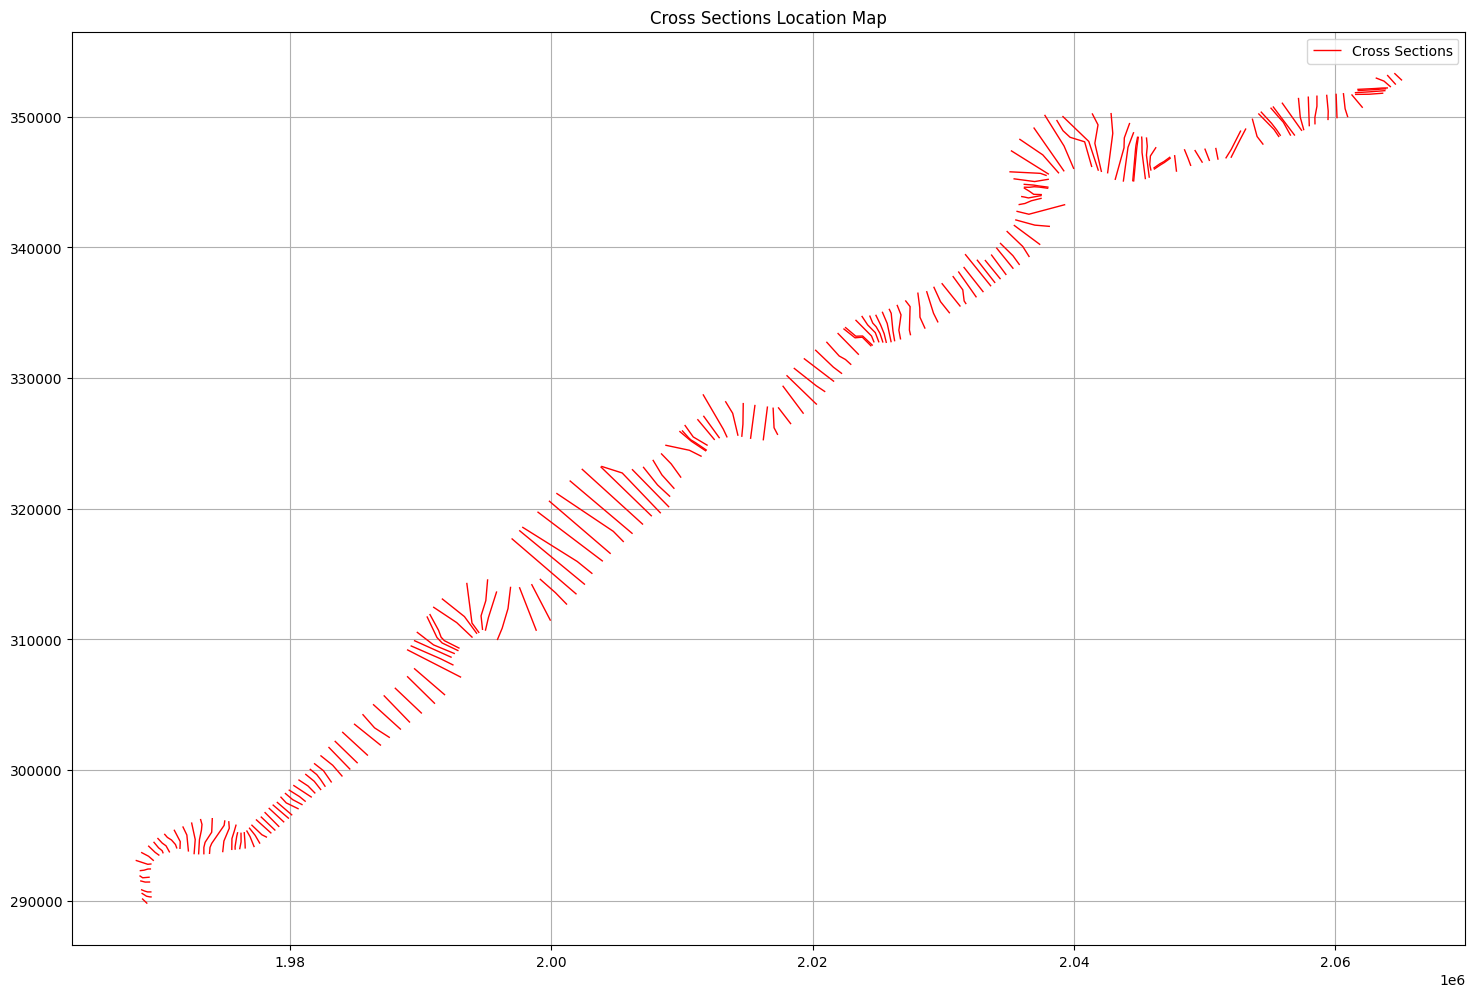

In [38]:
# Plot cross sections on map with matplotlib

if generate_plots:
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15,10))
    
    # Plot cross sections
    cross_sections_gdf.plot(ax=ax, color='red', linewidth=1, label='Cross Sections')
    
    # Add river name and reach labels
    #for idx, row in cross_sections_gdf.iterrows():
    #    # Get midpoint of cross section line for label placement
    #    midpoint = row.geometry.centroid
    #    label = f"{row['River']}\n{row['Reach']}\nRS: {row['RS']}"
    #    ax.annotate(label, (midpoint.x, midpoint.y), 
    #               xytext=(5, 5), textcoords='offset points',
    #               fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
    
    # Customize plot
    ax.set_title('Cross Sections Location Map')
    ax.grid(True)
    ax.legend()
    
    # Equal aspect ratio to preserve shape
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

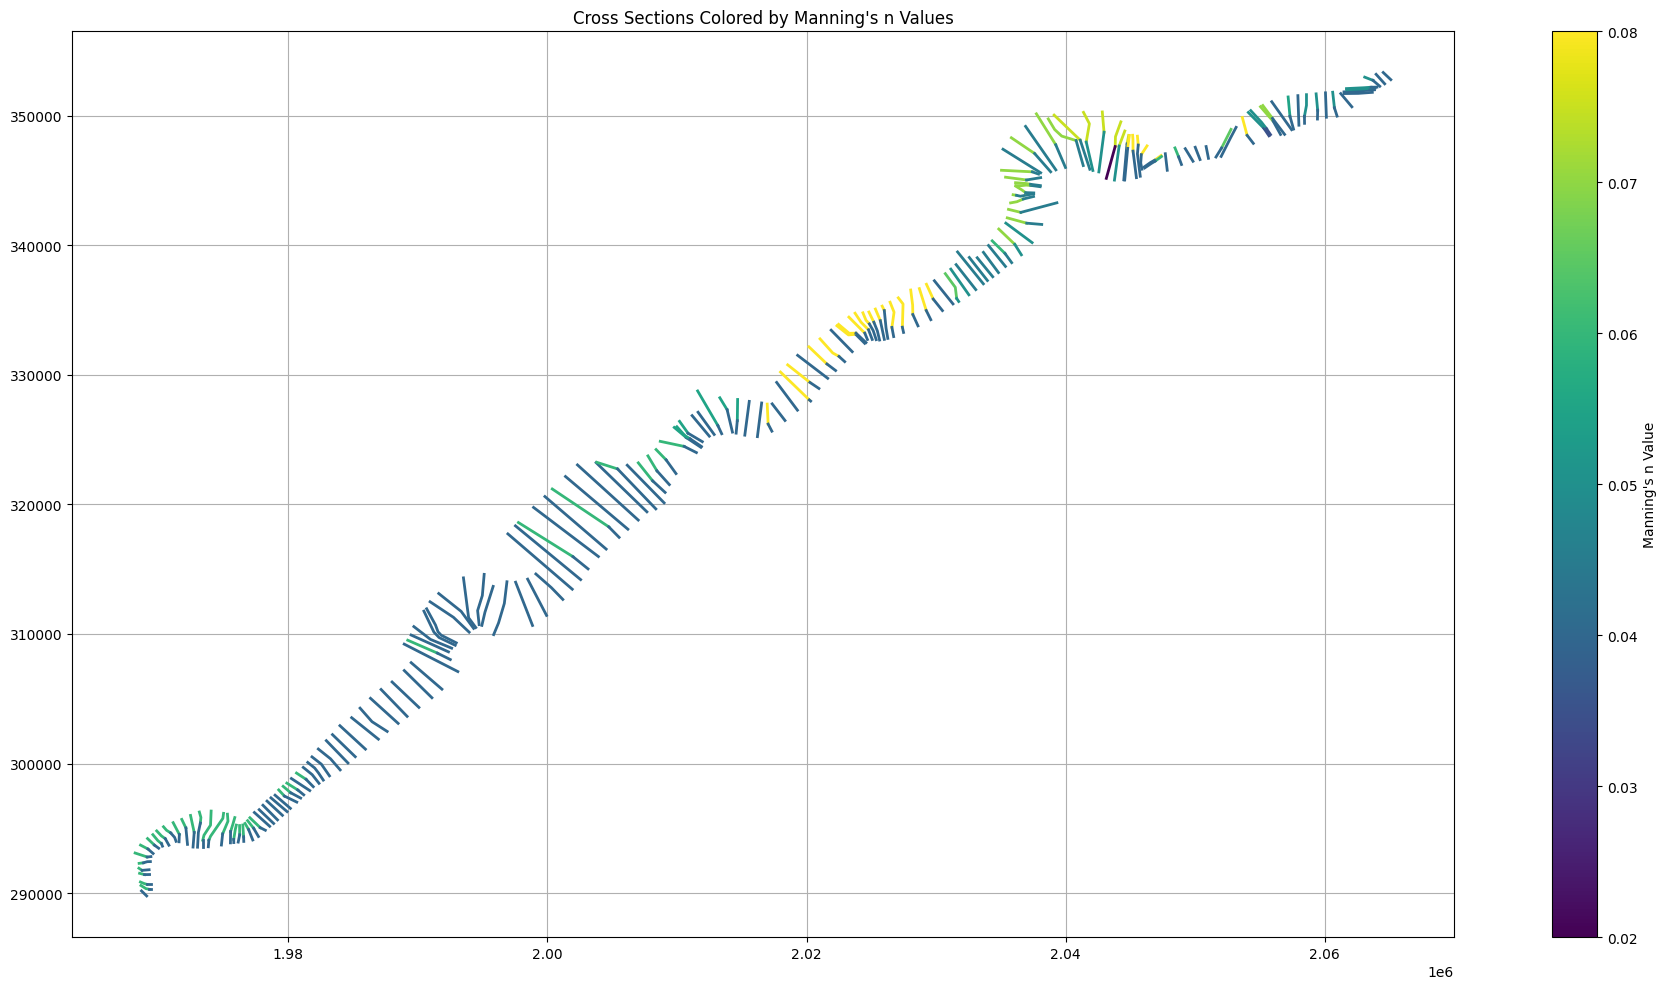

In [39]:
# Plot cross sections with Manning's n values colored by value

if generate_plots:
    # Create figure
    fig, ax1 = plt.subplots(figsize=(20,10))

    # Create colormap
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=0.02, vmax=0.08)  # Typical Manning's n range

    # Plot cross sections colored by Manning's n
    for idx, row in cross_sections_gdf.iterrows():
        # Extract Manning's n values and stations
        mannings = row['mannings_n']
        n_values = mannings['Mann n']
        stations = mannings['Station']
        
        # Get the full linestring coordinates
        line_coords = list(row.geometry.coords)
        
        # Calculate total length of the cross section
        total_length = row.geometry.length
        
        # For each Manning's n segment
        for i in range(len(n_values)-1):
            # Calculate the start and end proportions along the line
            start_prop = stations[i] / stations[-1]
            end_prop = stations[i+1] / stations[-1]
            
            # Get the start and end points for this segment
            start_idx = int(start_prop * (len(line_coords)-1))
            end_idx = int(end_prop * (len(line_coords)-1))
            
            # Extract the segment coordinates
            segment_coords = line_coords[start_idx:end_idx+1]
            
            if len(segment_coords) >= 2:
                # Create a line segment
                segment = LineString(segment_coords)
                
                # Get color from colormap for this n value
                color = cmap(norm(n_values[i]))
                
                # Plot the segment
                ax1.plot(*segment.xy, color=color, linewidth=2)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax1, label="Manning's n Value")

    ax1.set_title("Cross Sections Colored by Manning's n Values")
    ax1.grid(True)
    ax1.set_aspect('equal')

    plt.tight_layout()
    plt.show()

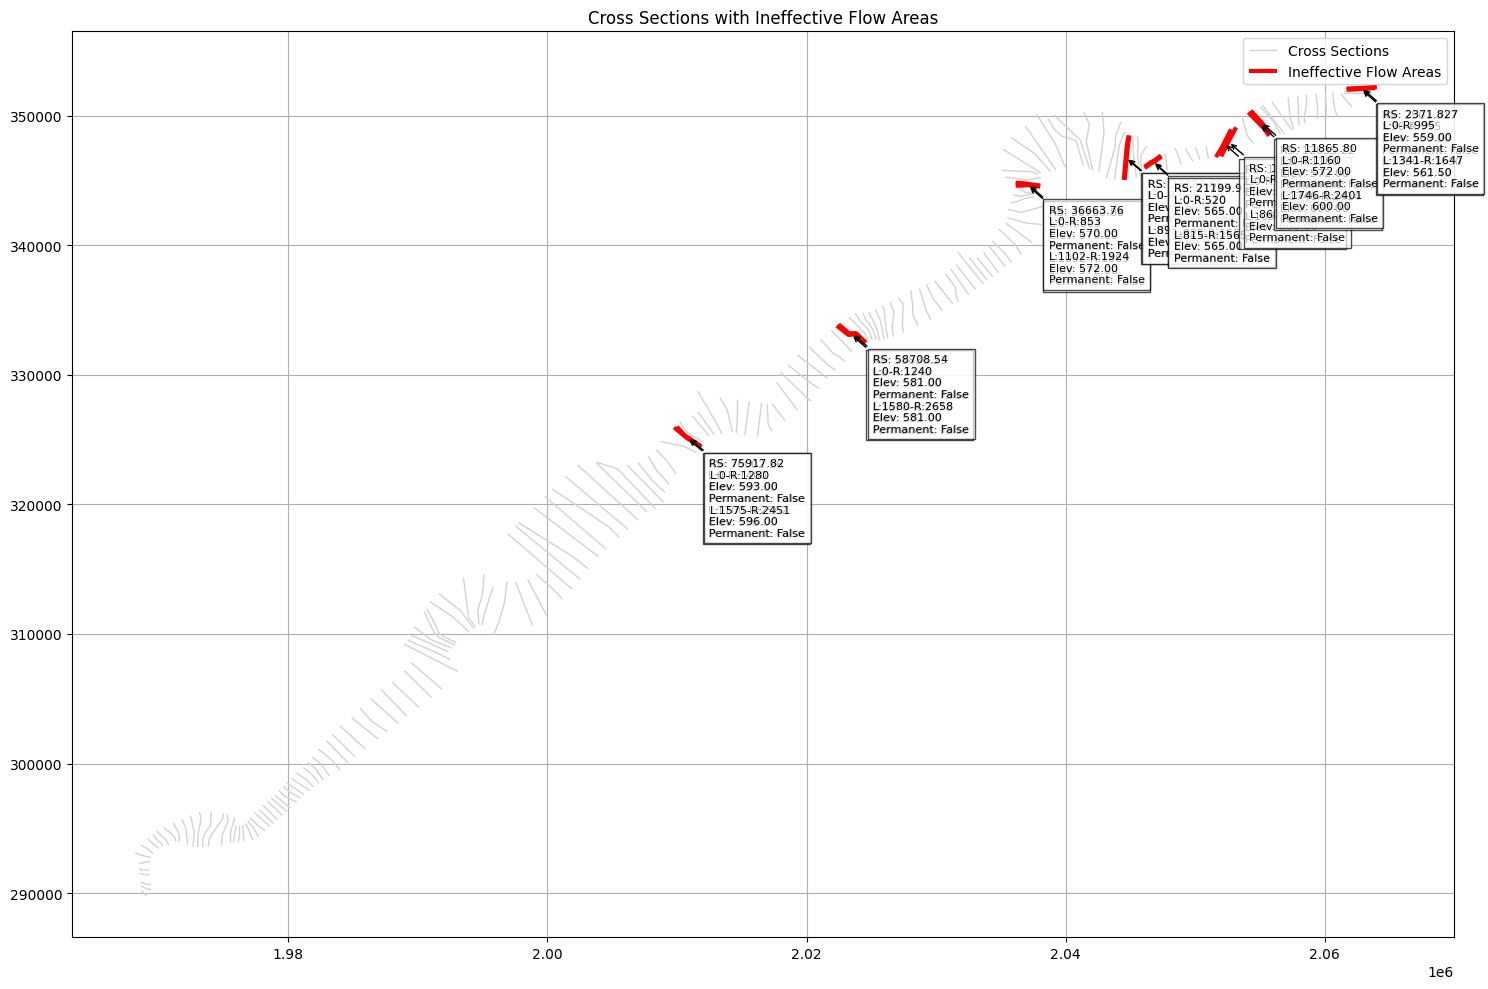

In [40]:
# Plot cross sections with ineffective flow areas

if generate_plots:
    # Create figure
    fig, ax2 = plt.subplots(figsize=(20,10))

    # Plot all cross sections first
    cross_sections_gdf.plot(ax=ax2, color='lightgray', linewidth=1, label='Cross Sections')

    # Plot ineffective flow areas with thicker lines
    ineffective_sections = cross_sections_gdf[cross_sections_gdf['ineffective_blocks'].apply(lambda x: len(x) > 0)]
    ineffective_sections.plot(ax=ax2, color='red', linewidth=3, label='Ineffective Flow Areas')

    # Add ineffective flow area labels with offset to lower right
    for idx, row in cross_sections_gdf.iterrows():
        # Get midpoint of cross section line
        midpoint = row.geometry.centroid
        
        # Extract ineffective flow blocks
        ineff_blocks = row['ineffective_blocks']
        
        if ineff_blocks:  # Only label if there are ineffective blocks
            label_parts = []
            # Add RS to first line of label
            label_parts.append(f"RS: {row['RS']}")
            for block in ineff_blocks:
                label_parts.append(
                    f"L:{block['Left Sta']:.0f}-R:{block['Right Sta']:.0f}\n"
                    f"Elev: {block['Elevation']:.2f}\n"
                    f"Permanent: {block['Permanent']}"
                )
            
            label = '\n'.join(label_parts)
            
            ax2.annotate(label, (midpoint.x, midpoint.y),
                        xytext=(15, -15),  # Offset to lower right
                        textcoords='offset points',
                        fontsize=8, 
                        bbox=dict(facecolor='white', alpha=0.7),
                        arrowprops=dict(arrowstyle='->'),
                        horizontalalignment='left',
                        verticalalignment='top')

    ax2.set_title('Cross Sections with Ineffective Flow Areas')
    ax2.grid(True)
    ax2.legend()
    ax2.set_aspect('equal')

    plt.tight_layout()
    plt.show()

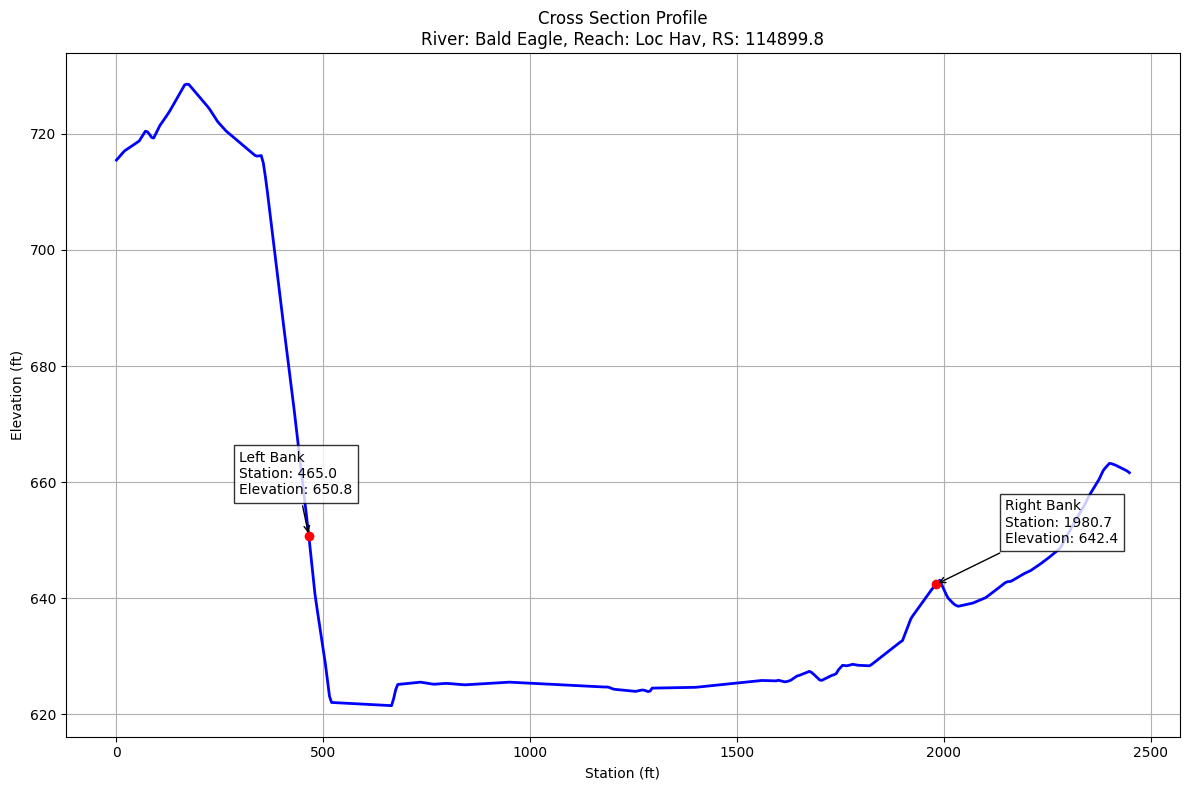

In [41]:
# Plot cross section elevation for cross section 42
if generate_plots:
    # Get cross sections data
    cross_sections_gdf = HdfXsec.get_cross_sections(geom_hdf_path)

    if not cross_sections_gdf.empty:
        # Get station-elevation data for cross section 42
        station_elevation = cross_sections_gdf.iloc[42]['station_elevation']
        
        # Convert list of lists to numpy arrays for plotting
        stations = np.array([point[0] for point in station_elevation])
        elevations = np.array([point[1] for point in station_elevation])
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(12,8))
        
        # Plot cross section
        ax.plot(stations, elevations, 'b-', linewidth=2)
        
        # Add labels and title
        river = cross_sections_gdf.iloc[42]['River']
        reach = cross_sections_gdf.iloc[42]['Reach'] 
        rs = cross_sections_gdf.iloc[42]['RS']
        
        # Show bank stations as dots
        left_bank_station = cross_sections_gdf.iloc[42]['Left Bank']
        right_bank_station = cross_sections_gdf.iloc[42]['Right Bank']
        
        # Get elevations at bank stations
        left_bank_elev = elevations[np.searchsorted(stations, left_bank_station)]
        right_bank_elev = elevations[np.searchsorted(stations, right_bank_station)]
        
        # Plot bank stations with dots
        ax.plot(left_bank_station, left_bank_elev, 'ro')
        ax.plot(right_bank_station, right_bank_elev, 'ro')
        
        # Add bank station labels with station and elevation
        ax.annotate(f'Left Bank\nStation: {left_bank_station:.1f}\nElevation: {left_bank_elev:.1f}',
                   (left_bank_station, left_bank_elev),
                   xytext=(-50, 30),
                   textcoords='offset points',
                   bbox=dict(facecolor='white', alpha=0.8),
                   arrowprops=dict(arrowstyle='->'))
                   
        ax.annotate(f'Right Bank\nStation: {right_bank_station:.1f}\nElevation: {right_bank_elev:.1f}',
                   (right_bank_station, right_bank_elev), 
                   xytext=(50, 30),
                   textcoords='offset points',
                   bbox=dict(facecolor='white', alpha=0.8),
                   arrowprops=dict(arrowstyle='->'))
        
        ax.set_title(f'Cross Section Profile\nRiver: {river}, Reach: {reach}, RS: {rs}')
        ax.set_xlabel('Station (ft)')
        ax.set_ylabel('Elevation (ft)')
        
        # Add grid
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()


In [42]:
# Get river centerlines as geodataframe
centerlines_gdf = HdfXsec.get_river_centerlines(geom_hdf_path)

2026-01-12 00:29:25 - ras_commander.hdf.HdfXsec - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfXsec - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_

In [43]:
print("\nRiver Centerlines:")
centerlines_gdf


River Centerlines:


,River Name,Reach Name,US Type,US Name,DS Type,DS Name,Junction to US XS,DS XS to Junction,geometry,length
0,Bald Eagle,Loc Hav,External,,External,,NaN,NaN,"LINESTRING (1967609.38 288126.34, 1967754.63 2...",140451.729879


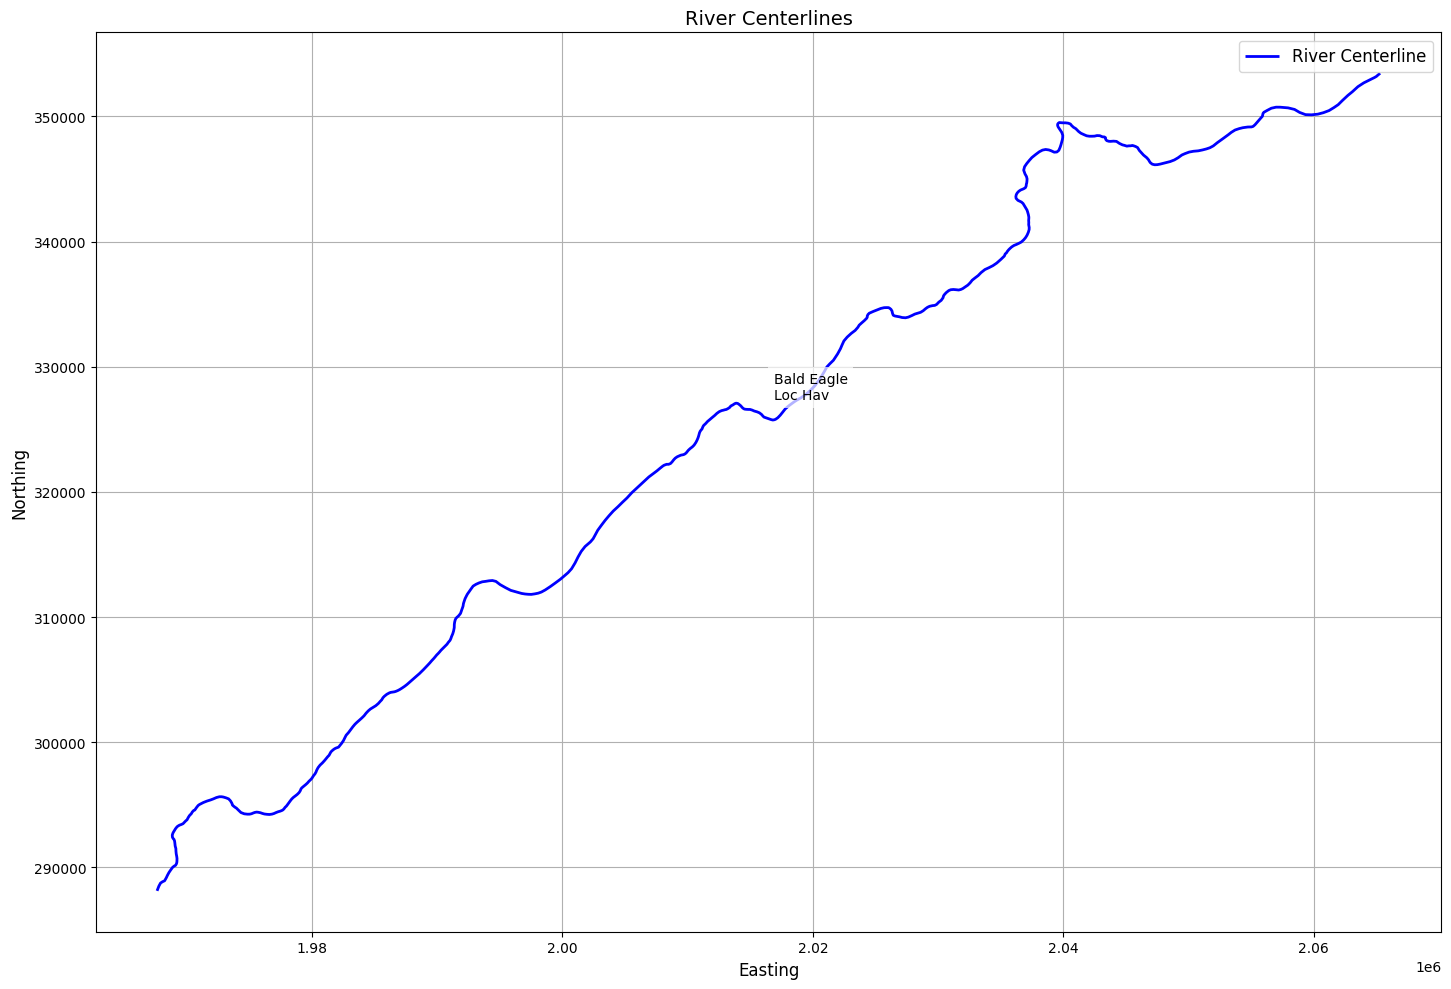

In [44]:
# Plot river centerlines with labels
if generate_plots:
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot centerlines
    centerlines_gdf.plot(ax=ax, color='blue', linewidth=2, label='River Centerline')

    # Add river/reach labels
    for idx, row in centerlines_gdf.iterrows():
        # Get midpoint of the line for label placement
        midpoint = row.geometry.interpolate(0.5, normalized=True)
        
        # Create label text combining river and reach names
        label = f"{row['River Name']}\n{row['Reach Name']}"
        
        # Add text annotation
        ax.annotate(label, 
                    xy=(midpoint.x, midpoint.y),
                    xytext=(10, 10), # Offset text slightly
                    textcoords='offset points',
                    fontsize=10,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    # Add labels and title
    ax.set_title('River Centerlines', fontsize=14)
    ax.set_xlabel('Easting', fontsize=12)
    ax.set_ylabel('Northing', fontsize=12)

    # Add legend
    ax.legend(fontsize=12)

    # Add grid
    ax.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()



In [45]:
# Get river edge lines as geodataframe
edge_lines_gdf = HdfXsec.get_river_edge_lines(geom_hdf_path)


2026-01-12 00:29:25 - ras_commander.hdf.HdfXsec - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfXsec - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_

In [46]:
print("\nRiver Edge Lines:")
edge_lines_gdf


River Edge Lines:


,edge_id,bank_side,geometry,length
0,NaN,NaN,"LINESTRING (1968668.17 290166.79, 1968673.632 ...",141615.154108
1,NaN,NaN,"LINESTRING (1969067.87 289778.85, 1969194.669 ...",130396.337697


In [47]:
# Get bank lines as geodataframe
bank_lines_gdf = HdfXsec.get_river_bank_lines(geom_hdf_path)


2026-01-12 00:29:25 - ras_commander.hdf.HdfXsec - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfXsec - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.g01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfBase - INFO - Using existing Path object HDF file: C:\Users\billk_

In [48]:
print("\nRiver Bank Lines:")
bank_lines_gdf


River Bank Lines:


,bank_id,bank_side,geometry,length
0,0,Left,"LINESTRING (1968804.51 290034.461, 1968930.093...",139546.829503
1,1,Right,"LINESTRING (1968937.263 289905.614, 1969101.06...",139349.187666


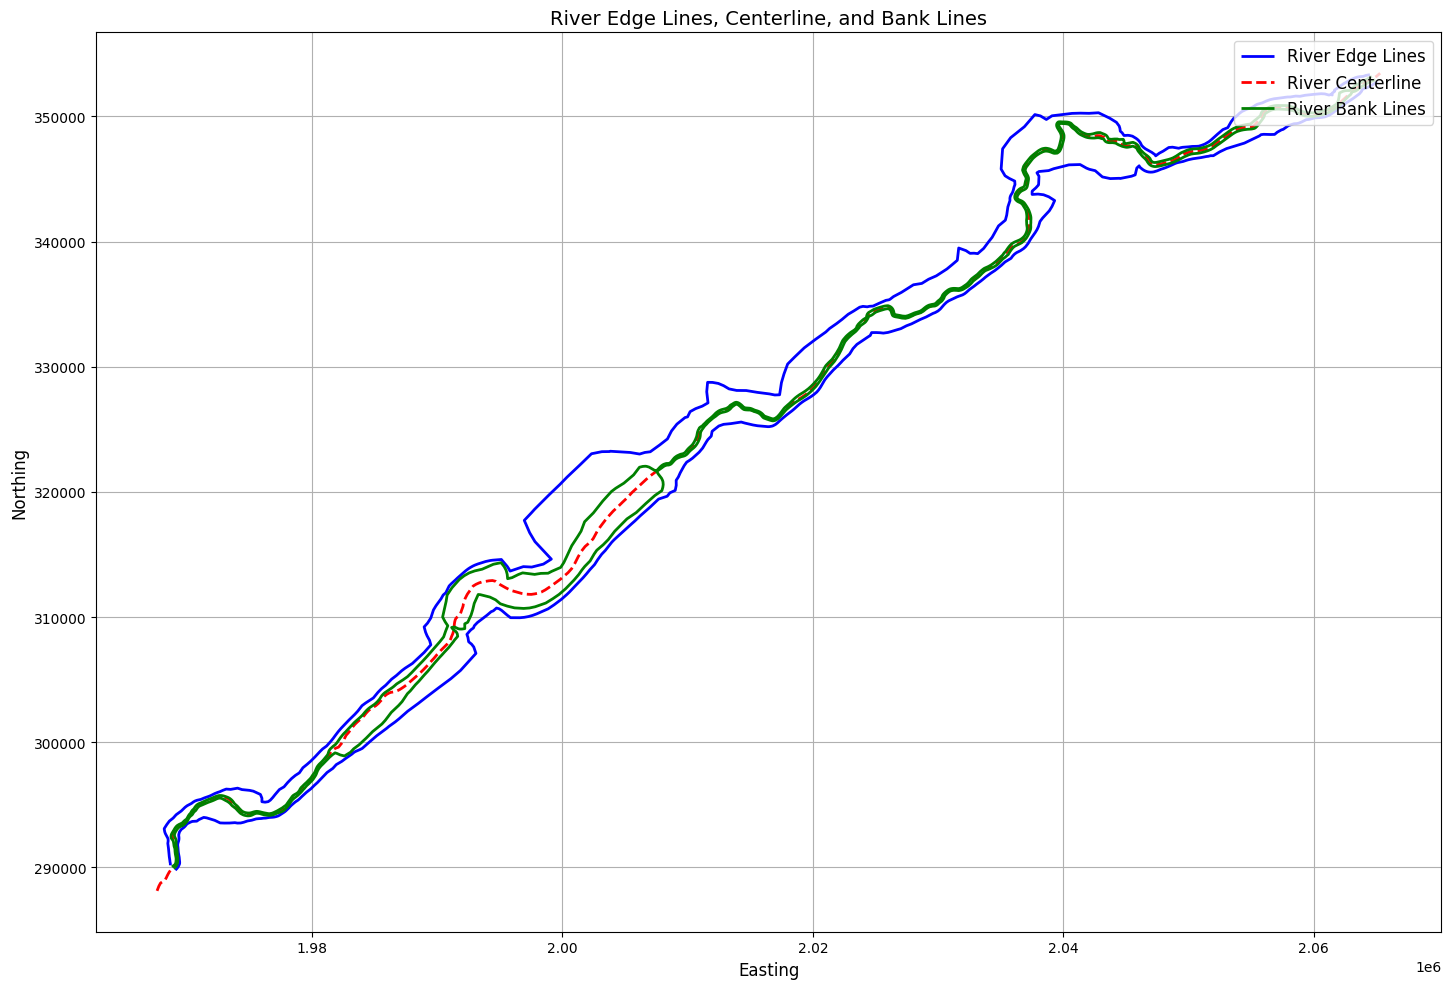

In [49]:
# Create figure and axis

if generate_plots:
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot river edge lines
    edge_lines_gdf.plot(ax=ax, color='blue', linewidth=2, label='River Edge Lines')

    # Plot centerlines for reference
    centerlines_gdf.plot(ax=ax, color='red', linewidth=2, linestyle='--', label='River Centerline')

    # Plot river bank lines
    bank_lines_gdf.plot(ax=ax, color='green', linewidth=2, label='River Bank Lines')

    # Add title and labels
    ax.set_title('River Edge Lines, Centerline, and Bank Lines', fontsize=14)
    ax.set_xlabel('Easting', fontsize=12)
    ax.set_ylabel('Northing', fontsize=12)

    # Add legend
    ax.legend(fontsize=12)

    # Add grid
    ax.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


Structures Summary:
Number of structures found: 11

Structure Details:
   Structure ID
0             1
1             2
2             3
3             4
4             5


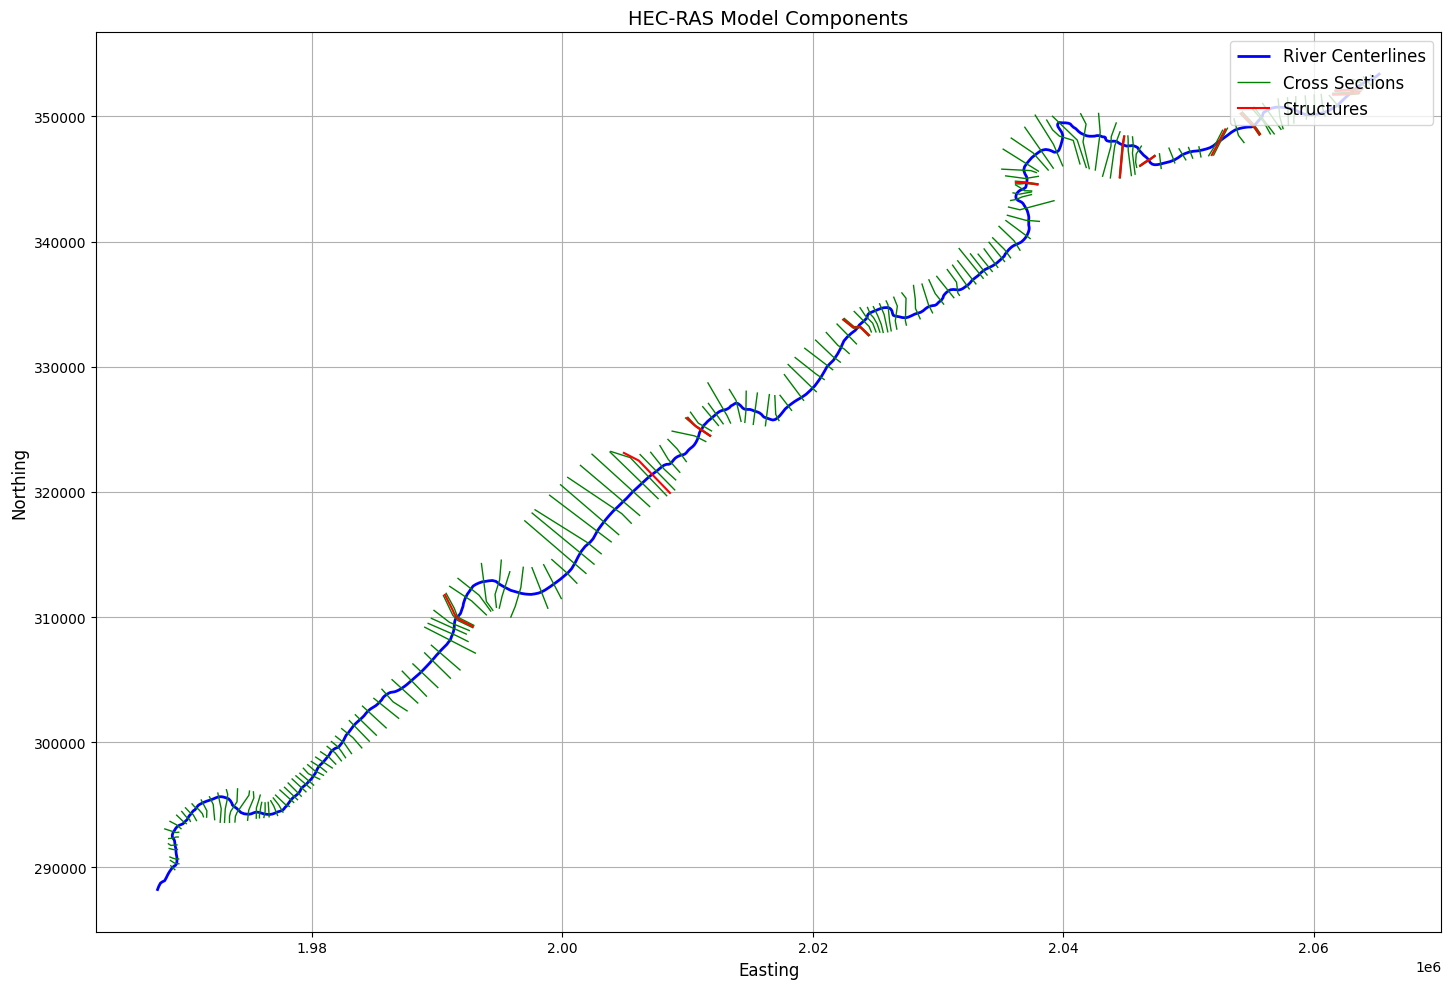


Cross Sections Summary:
Number of cross sections found: 178

Cross Section Details:
        River    Reach
0  Bald Eagle  Loc Hav
1  Bald Eagle  Loc Hav
2  Bald Eagle  Loc Hav
3  Bald Eagle  Loc Hav
4  Bald Eagle  Loc Hav


In [50]:
# Extract 1D Structures Geodataframe



# Display basic information about the structures
print("\nStructures Summary:")
print(f"Number of structures found: {len(structures_gdf)}")
structures_gdf

# Display first few rows of key attributes
print("\nStructure Details:")
display_cols = ['Structure ID', 'Structure Type', 'River Name', 'Reach Name', 'Station']
display_cols = [col for col in display_cols if col in structures_gdf.columns]
if display_cols:
    print(structures_gdf[display_cols].head())


if generate_plots:

    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot river centerlines
    if not centerlines_gdf.empty:
        centerlines_gdf.plot(ax=ax, color='blue', linewidth=2, label='River Centerlines')

    # Plot cross sections
    if not cross_sections_gdf.empty:
        cross_sections_gdf.plot(ax=ax, color='green', linewidth=1, label='Cross Sections')

    # Plot structures
    if not structures_gdf.empty:
        structures_gdf.plot(ax=ax, color='red', marker='s', markersize=100, label='Structures')

    # Add title and labels
    ax.set_title('HEC-RAS Model Components', fontsize=14)
    ax.set_xlabel('Easting', fontsize=12)
    ax.set_ylabel('Northing', fontsize=12)

    # Add legend
    ax.legend(fontsize=12)

    # Add grid
    ax.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# Print summary of cross sections
print("\nCross Sections Summary:")
print(f"Number of cross sections found: {len(cross_sections_gdf)}")
if not cross_sections_gdf.empty:
    print("\nCross Section Details:")
    xs_display_cols = ['River', 'Reach', 'Station']
    xs_display_cols = [col for col in xs_display_cols if col in cross_sections_gdf.columns]
    if xs_display_cols:
        print(cross_sections_gdf[xs_display_cols].head())


In [51]:
# Extract Plan Parameters
print("\nExample 12: Extracting Plan Parameters and Volume Accounting Data")

plan_parameters_df = HdfPlan.get_plan_parameters(hdf_path=plan_hdf_path)

2026-01-12 00:29:25 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf



Example 12: Extracting Plan Parameters and Volume Accounting Data


In [52]:
print("\nPlan Parameters DataFrame:")
plan_parameters_df


Plan Parameters DataFrame:


,Plan,Parameter,Value
0,01,1D Cores,2
1,01,1D Flow Tolerance,NaN
2,01,1D Maximum Iterations,20
3,01,1D Maximum Iterations Without Improvement,0
4,01,1D Maximum Water Surface Error To Abort,100.0
5,01,1D Methodology,Finite Difference
6,01,1D Storage Area Elevation Tolerance,0.1
7,01,1D Theta,1.0
8,01,1D Theta Warmup,1.0
9,01,1D Water Surface Elevation Tolerance,0.01


In [53]:
# Extract volume accounting data
volume_accounting_df = HdfResultsPlan.get_volume_accounting(hdf_path=plan_hdf_path)

2026-01-12 00:29:25 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf


In [54]:
print("\nVolume Accounting DataFrame:")
volume_accounting_df


Volume Accounting DataFrame:


,Error,Error Percent,Total Boundary Flux of Water In,Total Boundary Flux of Water Out,Vol Accounting in,Volume Ending,Volume Starting
0,-29.546846,0.014071,200682.453125,112574.828125,Acre Feet,97384.882812,9306.797852


In [55]:
# Get simulation start time
start_time = HdfPlan.get_plan_start_time(plan_hdf_path)
print(f"Simulation start time: {start_time}")

2026-01-12 00:29:25 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf


Simulation start time: 1999-02-18 00:00:00


In [56]:
# Get plan end time
end_time = HdfPlan.get_plan_end_time(plan_hdf_path)
print(f"Simulation end time: {end_time}")

2026-01-12 00:29:25 - ras_commander.hdf.HdfPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf


Simulation end time: 1999-02-24 05:00:00


In [57]:
# Get cross section results timeseries
xsec_results_xr = HdfResultsXsec.get_xsec_timeseries(plan_hdf_path)
print("\nCross Section Results Shape:", xsec_results_xr['Water_Surface'].shape)

2026-01-12 00:29:25 - ras_commander.hdf.HdfResultsXsec - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:25 - ras_commander.hdf.HdfResultsXsec - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf



Cross Section Results Shape: (150, 178)


In [58]:
xsec_results_xr

<xarray.Dataset> Size: 587kB
Dimensions:                   (time: 150, cross_section: 178)
Coordinates:
  * time                      (time) datetime64[ns] 1kB 1999-02-18 ... 1999-0...
  * cross_section             (cross_section) <U42 30kB 'Bald Eagle       Loc...
    River                     (cross_section) <U10 7kB 'Bald Eagle' ... 'Bald...
    Reach                     (cross_section) <U7 5kB 'Loc Hav' ... 'Loc Hav'
    Station                   (cross_section) <U8 6kB '138154.4' ... '659.942'
    Name                      (cross_section) <U1 712B '' '' '' '' ... '' '' ''
    Maximum_Water_Surface     (cross_section) float32 712B 672.8 672.8 ... 561.4
    Maximum_Flow              (cross_section) float32 712B 5e+04 ... 2.543e+04
    Maximum_Channel_Velocity  (cross_section) float32 712B 11.81 8.031 ... 2.028
    Maximum_Velocity_Total    (cross_section) float32 712B 9.371 5.379 ... 1.632
    Maximum_Flow_Lateral      (cross_section) float32 712B 0.0 0.0 ... 0.0 0.0
Data variables:
    Water_Surface             (time, cross_section) float32 107kB 660.7 ... 5...
    Velocity_Total            (time, cross_section) float32 107kB 0.0 ... 1.227
    Velocity_Channel          (time, cross_section) float32 107kB 0.0 ... 1.286
    Flow_Lateral              (time, cross_section) float32 107kB 0.0 ... 0.0
    Flow                      (time, cross_section) float32 107kB 2e+03 ... 2...
Attributes:
    description:  Cross-section results extracted from HEC-RAS HDF file
    source_file:  C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-...

In [59]:
# Plot the time of maximum water surface elevation (WSEL) for cross sections



# Get cross section geometry data
xsec_geom = HdfXsec.get_cross_sections(plan_hdf_path)
print("\nNumber of cross sections in geometry:", len(xsec_geom))

# Create dataframe with cross section locations and max WSEL times
xs_data = []

# Extract water surface data from xarray Dataset
water_surface = xsec_results_xr['Water_Surface'].values
times = pd.to_datetime(xsec_results_xr.time.values)

# Debug print
print("\nFirst few cross section names:")
print(xsec_results_xr.cross_section.values[:5])

# Iterate through cross sections
for xs_idx in range(len(xsec_results_xr.cross_section)):
    # Get WSEL timeseries for this cross section
    wsel_series = water_surface[:, xs_idx]

    # Get cross section name and parse components
    xs_name = xsec_results_xr.cross_section.values[xs_idx]

    # Split the string and remove empty strings
    xs_parts = [part for part in xs_name.split() if part]

    if len(xs_parts) >= 3:
        # Parse River, Reach, RS from the parts
        # Format is typically: River Reach RS (e.g., "White Muncie 5124.979")
        river = xs_parts[0]
        reach = xs_parts[1]
        rs = xs_parts[-1]     # Last part is the station

        # Get geometry for this cross section
        xs_match = xsec_geom[
            (xsec_geom['River'] == river) &
            (xsec_geom['Reach'] == reach) &
            (xsec_geom['RS'] == rs)
        ]

        if not xs_match.empty:
            geom = xs_match.iloc[0]
            # Use first point of cross section line for plotting
            x = geom.geometry.coords[0][0]
            y = geom.geometry.coords[0][1]

            # Find time of max WSEL
            max_wsel_idx = np.argmax(wsel_series)
            max_wsel = np.max(wsel_series)
            max_time = times[max_wsel_idx]

            xs_data.append({
                'xs_name': xs_name,
                'x': x,
                'y': y,
                'max_wsel': max_wsel,
                'time_of_max': max_time
            })
        else:
            print(f"\nWarning: No geometry match found for {xs_name}")
            print(f"River: {river}, Reach: {reach}, RS: {rs}")
    else:
        print(f"\nWarning: Could not parse cross section name: {xs_name}")

# Create dataframe
xs_df = pd.DataFrame(xs_data)

# Debug print
print("\nNumber of cross sections processed:", len(xs_df))




if generate_plots:
    print("\nColumns in xs_df:", xs_df.columns.tolist())
    print("\nFirst row of xs_df:")
    if len(xs_df) > 0:
        print(xs_df.iloc[0])
    else:
        print("(No cross sections matched)")

    # Create the plot only if we have data
    if len(xs_df) == 0:
        print("No cross sections to plot - skipping")
    else:
        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Convert datetime to hours since start for colormap
        min_time = min(xs_df['time_of_max'])
        color_values = [(t - min_time).total_seconds() / 3600 for t in xs_df['time_of_max']]

        # Plot cross section points
        scatter = ax.scatter(xs_df['x'], xs_df['y'],
                            c=color_values,
                            cmap='viridis',
                            s=50)

        # Customize plot
        ax.set_title('Time of Maximum Water Surface Elevation at Cross Sections')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')

        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Hours since simulation start')

        # Format colorbar ticks
        max_hours = int(max(color_values))
        tick_interval = max(1, max_hours // 6)  # Show ~6 ticks
        cbar.set_ticks(range(0, max_hours + 1, tick_interval))
        cbar.set_ticklabels([f'{h}h' for h in range(0, max_hours + 1, tick_interval)])

        # Add grid and adjust styling
        ax.grid(True, linestyle='--', alpha=0.7)
        plt.rcParams.update({'font.size': 12})
        plt.tight_layout()

        # Show plot
        plt.show()

        # Print summary statistics
        max_wsel_xs = xs_df.loc[xs_df['max_wsel'].idxmax()]
        hours_since_start = (max_wsel_xs['time_of_max'] - min_time).total_seconds() / 3600

        print(f"\nOverall Maximum WSEL: {max_wsel_xs['max_wsel']:.2f} ft")
        print(f"Time of Overall Maximum WSEL: {max_wsel_xs['time_of_max']}")
        print(f"Hours since simulation start: {hours_since_start:.2f} hours")
        print(f"Location of Overall Maximum WSEL: X={max_wsel_xs['x']:.2f}, Y={max_wsel_xs['y']:.2f}")
        print(f"Cross Section: {max_wsel_xs['xs_name']}")



Number of cross sections in geometry: 178

First few cross section names:
['Bald Eagle       Loc Hav          138154.4'
 'Bald Eagle       Loc Hav          137690.8'
 'Bald Eagle       Loc Hav          137327.0'
 'Bald Eagle       Loc Hav          136564.9'
 'Bald Eagle       Loc Hav          136202.3']

River: Bald, Reach: Eagle, RS: 138154.4

River: Bald, Reach: Eagle, RS: 137690.8

River: Bald, Reach: Eagle, RS: 137327.0

River: Bald, Reach: Eagle, RS: 136564.9

River: Bald, Reach: Eagle, RS: 136202.3

River: Bald, Reach: Eagle, RS: 135591.4

River: Bald, Reach: Eagle, RS: 135068.7

River: Bald, Reach: Eagle, RS: 134487.2

River: Bald, Reach: Eagle, RS: 133881.0

River: Bald, Reach: Eagle, RS: 133446.1

River: Bald, Reach: Eagle, RS: 132973.6

River: Bald, Reach: Eagle, RS: 132363.8

River: Bald, Reach: Eagle, RS: 131699.7

River: Bald, Reach: Eagle, RS: 130997.6

River: Bald, Reach: Eagle, RS: 130339.2

River: Bald, Reach: Eagle, RS: 129627.5

River: Bald, Reach: Eagle, RS: 128760

In [60]:
# Get unsteady attributes as dataframe
results_unsteady_attrs = HdfResultsPlan.get_unsteady_info(plan_hdf_path)

2026-01-12 00:29:26 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:26 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf


In [61]:
results_unsteady_attrs

,Plan Title,Program Name,Program Version,Project File Name,Project Title,Short ID,Simulation Time Window,Type of Run
0,Unsteady with Bridges and Dam,HEC-RAS - River Analysis System,HEC-RAS 6.6 September 2024,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Bald Eagle Cr. for the WCDS Project,UnsteadyFlow,17Feb1999 2400 to 24Feb1999 0500,Unsteady Flow Analysis


In [62]:
# Get unsteady summary attributes as dataframe
results_unsteady_summary_attrs = HdfResultsPlan.get_unsteady_summary(plan_hdf_path)

2026-01-12 00:29:26 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:26 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf


In [63]:
results_unsteady_summary_attrs

,Computation Time DSS,Computation Time Total,Maximum WSEL Error,Maximum number of cores,Run Time Window,Solution,Time Solution Went Unstable,Time Stamp Solution Went Unstable
0,00:00:00,00:00:02,0.009995,1,12JAN2026 00:29:12 to 12JAN2026 00:29:14,Unsteady Finished Successfully,NaN,Not Applicable


# 1D Cross Section Results as Xarray

In [64]:
# Get cross section results timeseries as xarray dataset
xsec_results_xr = HdfResultsXsec.get_xsec_timeseries(plan_hdf_path)

2026-01-12 00:29:26 - ras_commander.hdf.HdfResultsXsec - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:26 - ras_commander.hdf.HdfResultsXsec - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf


In [65]:
xsec_results_xr

<xarray.Dataset> Size: 587kB
Dimensions:                   (time: 150, cross_section: 178)
Coordinates:
  * time                      (time) datetime64[ns] 1kB 1999-02-18 ... 1999-0...
  * cross_section             (cross_section) <U42 30kB 'Bald Eagle       Loc...
    River                     (cross_section) <U10 7kB 'Bald Eagle' ... 'Bald...
    Reach                     (cross_section) <U7 5kB 'Loc Hav' ... 'Loc Hav'
    Station                   (cross_section) <U8 6kB '138154.4' ... '659.942'
    Name                      (cross_section) <U1 712B '' '' '' '' ... '' '' ''
    Maximum_Water_Surface     (cross_section) float32 712B 672.8 672.8 ... 561.4
    Maximum_Flow              (cross_section) float32 712B 5e+04 ... 2.543e+04
    Maximum_Channel_Velocity  (cross_section) float32 712B 11.81 8.031 ... 2.028
    Maximum_Velocity_Total    (cross_section) float32 712B 9.371 5.379 ... 1.632
    Maximum_Flow_Lateral      (cross_section) float32 712B 0.0 0.0 ... 0.0 0.0
Data variables:
    Water_Surface             (time, cross_section) float32 107kB 660.7 ... 5...
    Velocity_Total            (time, cross_section) float32 107kB 0.0 ... 1.227
    Velocity_Channel          (time, cross_section) float32 107kB 0.0 ... 1.286
    Flow_Lateral              (time, cross_section) float32 107kB 0.0 ... 0.0
    Flow                      (time, cross_section) float32 107kB 2e+03 ... 2...
Attributes:
    description:  Cross-section results extracted from HEC-RAS HDF file
    source_file:  C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-...


Time Series Data for Cross Section: Bald Eagle       Loc Hav          138154.4

Water_Surface:
[660.65106 659.7748  660.21893 660.77985 661.3133 ]

Velocity_Total:
[0.        3.011383  2.9495692 2.9549372 3.069316 ]

Velocity_Channel:
[0.        3.4043593 3.515353  3.6983044 3.8560863]

Flow_Lateral:
[0. 0. 0. 0. 0.]

Flow:
[2000.   1301.64 1676.94 2199.12 2864.95]


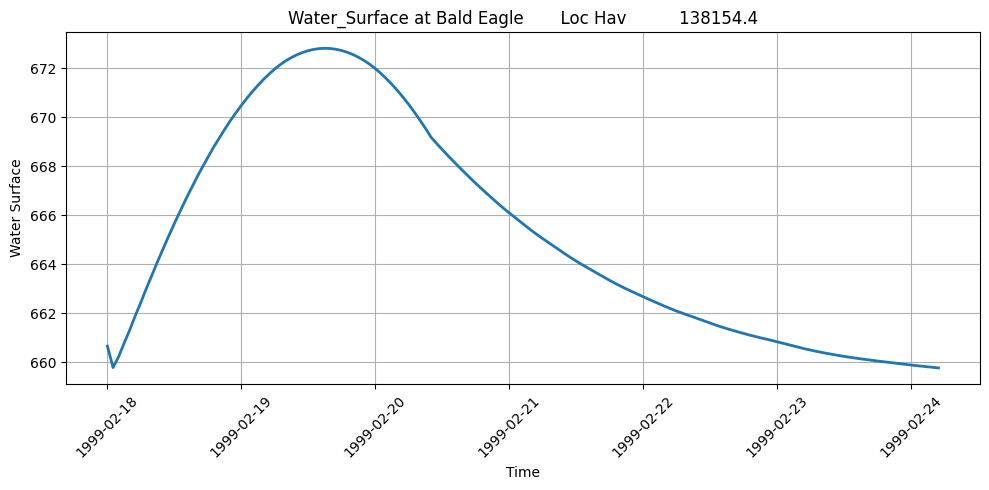

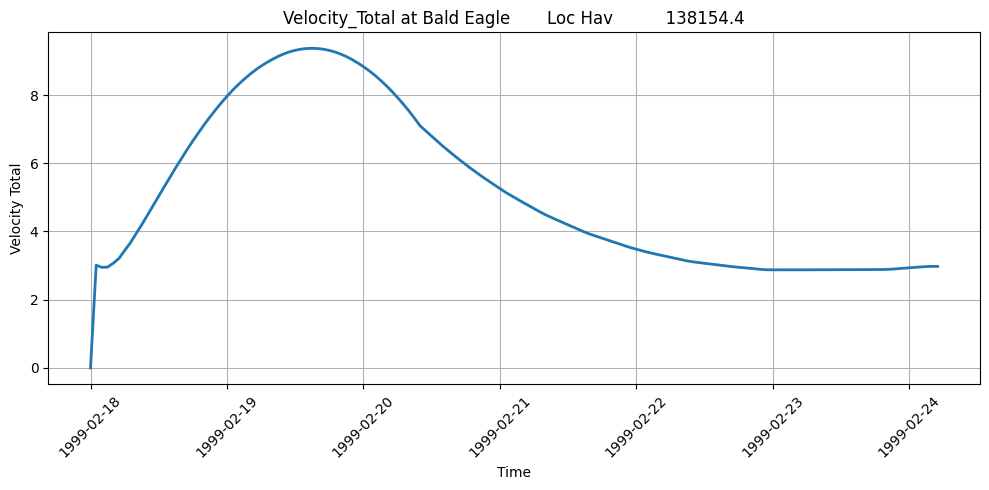

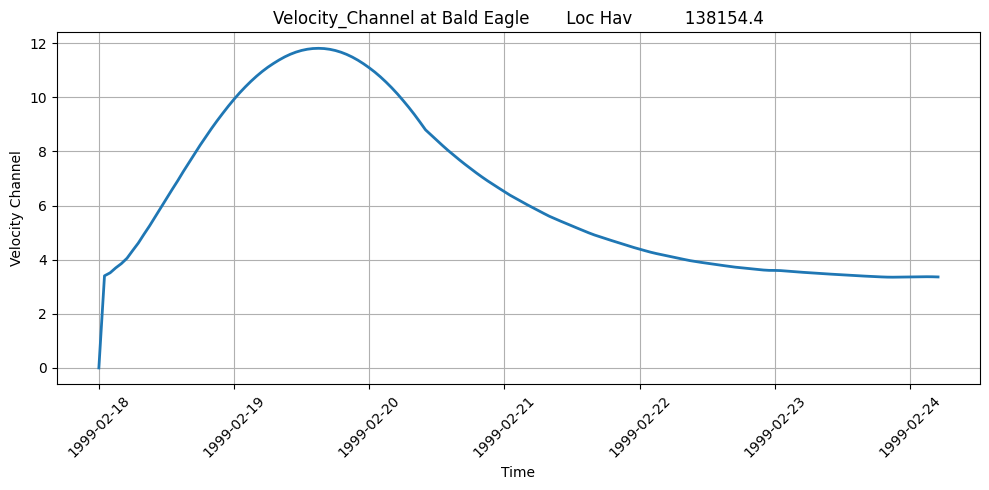

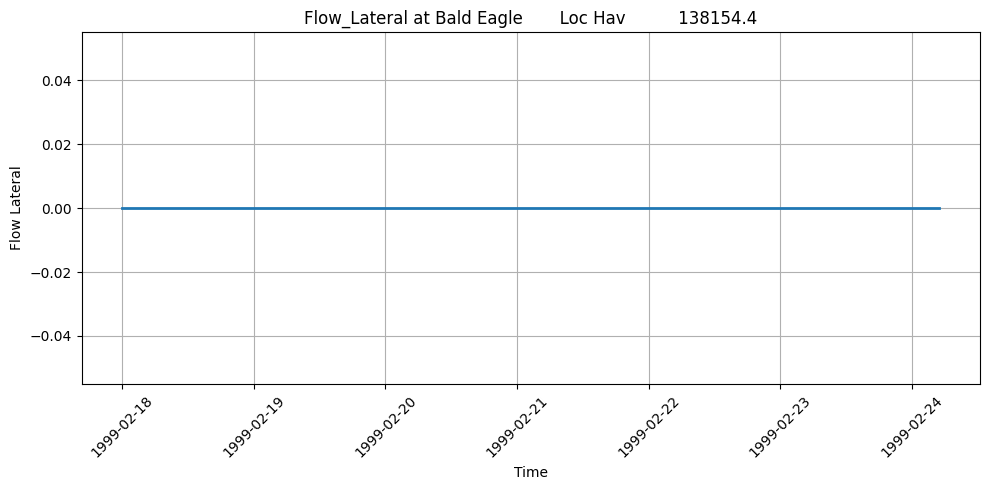

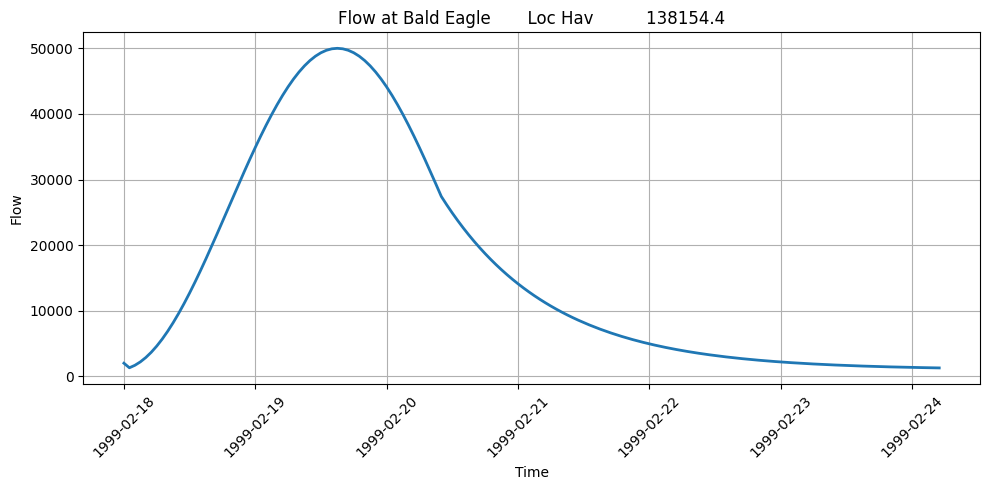

In [66]:
# Print time series for specific cross section
# Select first cross section from the data dynamically
target_xs = xsec_results_xr.cross_section.values[0]

print("\nTime Series Data for Cross Section:", target_xs)
for var in ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']:
    print(f"\n{var}:")
    print(xsec_results_xr[var].sel(cross_section=target_xs).values[:5])  # Show first 5 values

# Create time series plots

if generate_plots:

    # Create a figure for each variable
    variables = ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']

    for var in variables:
        plt.figure(figsize=(10, 5))
        # Convert time values to datetime if needed
        time_values = pd.to_datetime(xsec_results_xr.time.values)
        values = xsec_results_xr[var].sel(cross_section=target_xs).values
        
        # Plot with explicit x and y values
        plt.plot(time_values, values, '-', linewidth=2)
        
        plt.title(f'{var} at {target_xs}')
        plt.xlabel('Time')
        plt.ylabel(var.replace('_', ' '))
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Force display
        plt.draw()
        plt.pause(0.1)
        plt.show()


### Verification - Velocity

**Data Quality Checks**:
- **Value Range**: Velocity typically 0-30 ft/s for natural channels
- **Physical Limits**: Velocities > 50 ft/s may indicate modeling issues
- **Negative Values**: Should be rare (may occur at structures)
- **Peak Timing**: Should align with peak WSE and flow

**Typical Velocity Ranges** (U.S. units):
- Low flow: 0-2 ft/s
- Normal flow: 2-8 ft/s
- High flow: 8-20 ft/s
- Extreme flow: 20-30 ft/s
- *Values > 30 ft/s warrant investigation*

**Engineering Review**:
- Compare velocities to channel roughness assumptions
- Check for erosion potential (v > 6 ft/s in erodible channels)
- Verify peak velocities occur at expected locations

### Verification - Velocity

**Data Quality Checks**:
- **Value Range**: Velocity typically 0-30 ft/s for natural channels
- **Physical Limits**: Velocities > 50 ft/s may indicate modeling issues
- **Negative Values**: Should be rare (may occur at structures)
- **Peak Timing**: Should align with peak WSE and flow

**Typical Velocity Ranges** (U.S. units):
- Low flow: 0-2 ft/s
- Normal flow: 2-8 ft/s
- High flow: 8-20 ft/s
- Extreme flow: 20-30 ft/s
- *Values > 30 ft/s warrant investigation*

**Engineering Review**:
- Compare velocities to channel roughness assumptions
- Check for erosion potential (v > 6 ft/s in erodible channels)
- Verify peak velocities occur at expected locations

-----

# Advanced HDF Data Extraction
This section focuses on directly accessing the HDF file from a jupyter notebook for use cases not directly supported by the RAS-Commander libary:

In [67]:
# Extract Compute Messages using HdfResultsPlan
print("Extracting Compute Messages")

# Use the built-in function to extract computation messages from HDF
# This function automatically handles HDF extraction with fallback to .txt files if needed
compute_msgs = HdfResultsPlan.get_compute_messages(plan_number)

if compute_msgs:
    print("="*80)
    print("COMPUTATION MESSAGES")
    print("="*80)
    
    # Parse and display the messages in a readable format
    messages = compute_msgs.split('\r\n')
    
    # Display all messages with formatting
    for message in messages:
        if message.strip():  # Skip empty lines
            if ':' in message:
                # Format key-value pairs
                parts = message.split(':', 1)
                if len(parts) == 2:
                    key, value = parts
                    print(f"{key.strip():40} : {value.strip()}")
                else:
                    print(message)
            else:
                print(f"\n{message.strip()}")
    
    # Display computation summary table (if present)
    print("\n" + "="*80)
    print("COMPUTATION SUMMARY")
    print("="*80)
    summary_lines = [line for line in messages if 'Computation Task' in line or 'Computation Speed' in line]
    if summary_lines:
        for line in summary_lines:
            print(line)
    
    print("\n" + "="*80)
    print(f"Total message length: {len(compute_msgs)} characters")
    print("="*80)
else:
    print("No computation messages available for this plan.")
    print("\nNote: Computation messages are generated when HEC-RAS runs a plan.")
    print("If no messages are found, the plan may not have been computed yet.")

2026-01-12 00:29:27 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_10\BaldEagle.p01.hdf
2026-01-12 00:29:27 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagle.p01.hdf
2026-01-12 00:29:27 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 1694 characters from HDF


Extracting Compute Messages
COMPUTATION MESSAGES
Plan                                     : 'Unsteady with Bridges and Dam' (BaldEagle.p01)
Simulation started at                    : 12Jan2026 12:27:55 AM

Writing Plan GIS Data...

Completed Writing Plan GIS Data

Writing Geometry...

Computing Bank Lines

Bank lines generated in 111 ms

Computing Edge Lines

Edge Lines generated in 43 ms

Computing XS Interpolation Surface

XS Interpolation Surface generated in 117 ms

Completed Writing Geometry

Writing Event Conditions ...

Completed Writing Event Condition Data

Geometric Preprocessor HEC-RAS 6.6 September 2024

Finished Processing Geometry

Performing Unsteady Flow Simulation  HEC-RAS 6.6 September 2024
Unsteady Input Summary                   : 

1D Unsteady Finite Difference Numerical Solution
Overall Volume Accounting Error in Acre Feet : -29.5468461514
Overall Volume Accounting Error as percentage : 0.01407

Please review "Computational Log File" output for volume accounting d

## Exploring HDF Datasets with HdfBase.get_dataset_info
This allows users to find HDF information that is not included in the ras-commander library.  Find the path in HDFView and set the group_path below to explore the HDF datasets and attributes.  Then, use the output to write your own function to extract the data.  

# Get HDF Paths with Properties (For Exploring HDF Files)
HdfBase.get_dataset_info(plan_number, group_path="/Geometry")

#### Use get_hdf5_dataset_info function to get dataset structure:
HdfBase.get_dataset_info(plan_hdf_path, "/Geometry/River Bank Lines/")

#### Use get_hdf5_dataset_info function to get Pipe Conduits data:
HdfBase.get_dataset_info(plan_hdf_path, "/Geometry/Structures")


#### Use get_hdf5_dataset_info function to get Pipe Conduits data:
HdfBase.get_dataset_info(plan_hdf_path, "/Results/Unsteady/Output/Output Blocks/Computation Block/Global/")

#### Use the get_hdf5_dataset_info function from HdfUtils to explore the Cross Sections structure in the geometry HDF file

print("\nExploring Cross Sections structure in geometry file:")
print("HDF Base Path: /Geometry/Cross Sections ")
HdfBase.get_dataset_info(geom_hdf_path, group_path='/Geometry/Cross Sections')

print("\n=== HDF5 File Structure ===\n")
print(plan_hdf_path)
HdfBase.get_dataset_info(plan_hdf_path, group_path='/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections')

For HDF datasets that are not supported by the RAS-Commadner library, provide the dataset path to HdfBase.get_dataset_info and provide the output to an LLM along with a relevent HDF* class(es) to generate new functions that extend the library's coverage.   

## Common 1D HDF Extraction Patterns

### Pattern 1: Extract Maximum Values

```python
# Get maximum WSE at each cross section
max_wse = HdfResultsXsec.get_max_wse(plan_number, ras_object=ras)

# Typical use: Floodplain mapping, structure design
```

### Pattern 2: Extract at Specific Time

```python
# Get results at peak flow time
peak_time_index = flow_df.idxmax().iloc[0]  # Index of peak flow
wse_at_peak = hdf.get_wse(time_index=peak_time_index)

# Typical use: Critical condition analysis
```

### Pattern 3: Extract for Specific Reach

```python
# Filter to single river/reach
xs_list = ras.geometry.get_cross_sections(river="Bald Eagle", reach="Loc Hav")
wse_reach = wse_df[wse_df.index.isin(xs_list)]

# Typical use: Reach-specific analysis
```

### Pattern 4: Time Series at Critical Location

```python
# Extract full time series at single cross section
critical_xs = "138154.4"  # River station
wse_ts = wse_df[critical_xs]

# Plot hydrograph
plt.plot(wse_df.index, wse_ts)
plt.xlabel('Time')
plt.ylabel('WSE (ft)')
plt.title(f'Water Surface Elevation at XS {critical_xs}')
```

## Cross-References

- **2D Results**: See `410_2d_hdf_data_extraction.ipynb` for 2D mesh results
- **Steady Flow**: See `401_steady_flow_analysis.ipynb` for steady flow profiles
- **Breach Results**: See `420_breach_results_extraction.ipynb` for dam breach analysis
- **Structure Results**: See `411_2d_hdf_pipes_and_pumps.ipynb` for hydraulic structure data

## Common 1D HDF Extraction Patterns

### Pattern 1: Extract Maximum Values

```python
# Get maximum WSE at each cross section
max_wse = HdfResultsXsec.get_max_wse(plan_number, ras_object=ras)

# Typical use: Floodplain mapping, structure design
```

### Pattern 2: Extract at Specific Time

```python
# Get results at peak flow time
peak_time_index = flow_df.idxmax().iloc[0]  # Index of peak flow
wse_at_peak = hdf.get_wse(time_index=peak_time_index)

# Typical use: Critical condition analysis
```

### Pattern 3: Extract for Specific Reach

```python
# Filter to single river/reach
xs_list = ras.geometry.get_cross_sections(river="Bald Eagle", reach="Loc Hav")
wse_reach = wse_df[wse_df.index.isin(xs_list)]

# Typical use: Reach-specific analysis
```

### Pattern 4: Time Series at Critical Location

```python
# Extract full time series at single cross section
critical_xs = "138154.4"  # River station
wse_ts = wse_df[critical_xs]

# Plot hydrograph
plt.plot(wse_df.index, wse_ts)
plt.xlabel('Time')
plt.ylabel('WSE (ft)')
plt.title(f'Water Surface Elevation at XS {critical_xs}')
```

## Cross-References

- **2D Results**: See `410_2d_hdf_data_extraction.ipynb` for 2D mesh results
- **Steady Flow**: See `401_steady_flow_analysis.ipynb` for steady flow profiles
- **Breach Results**: See `420_breach_results_extraction.ipynb` for dam breach analysis
- **Structure Results**: See `411_2d_hdf_pipes_and_pumps.ipynb` for hydraulic structure data

## Summary: 1D HDF Data Extraction Capabilities

This notebook demonstrated comprehensive 1D HDF data extraction:

### Data Extraction
- Runtime and computation time data
- Geometry attributes and structures
- Cross sections with Manning's n, ineffective areas, elevations
- River centerlines, edge lines, and bank lines
- Plan parameters and volume accounting
- Unsteady time series results (WSE, flow, velocity)

### Output Discovery Methods
- **`HdfBase.get_dataset_info()`** - Explore any HDF group/dataset structure
- **`ras.plan_df`** - View available plans and their HDF paths
- **`ras.boundaries_df`** - List boundary conditions
- **`HdfResultsPlan.get_compute_messages()`** - Extract computation messages

### Key Patterns
1. Use plan number or HDF path interchangeably (decorator handles conversion)
2. Results returned as DataFrames, GeoDataFrames, or xarray for time series
3. Use `HdfBase.get_dataset_info()` to explore unsupported HDF paths